In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
ROOT = "/content/gdrive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)
drive.mount(ROOT,force_remount=True)           # we mount the google drive at /content/drive

/content/gdrive
Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/School_of_AI_ERA

/content/gdrive/MyDrive/School_of_AI_ERA


In [ ]:
# !git status

In [ ]:
# !cp "/content/gdrive/MyDrive/Colab Notebooks/S5.ipynb" /session5

## OPTIMIZED VERSION OF S4 ASSIGNMENT

Objective:\
Move the contents of the code to the following files-
* model.py
* utils.py
* train_utils.py
* S5.ipynb


### Imports

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

In [11]:
# training drivers
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device Available?", device)

batch_size = 128
epochs = 3
lr = 0.01

device Available? cuda


###Training and Testing data from torchvision datasets

#### Image transformers for basic preprocessing and augmentation

we will write the code to a python script first and import from there

In [12]:
%%writefile session5//utils.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),  # Apply randomly a list of transformations with a given probability
    transforms.Resize((28, 28)),  # Resize the image to the given size
    transforms.RandomRotation((-15., 15.), fill=0),  # Rotate the image by an angle
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.1307,), (0.3081,)), # Normalize a tensor image with mean and standard deviation.
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(), # PIL to tensor
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize a tensor image with mean and standard deviation.
    ])

Overwriting session5//utils.py


In [13]:
from session5.utils import train_transforms, test_transforms

#### Reading MNIST data

In [14]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=train_transforms)

In [15]:
print(train_data.data.shape)
print(test_data.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


#### Train test loader

In [16]:
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [17]:
# characteristics of one batch
for (data, target) in train_loader:
  print(data.shape)
  print(target.shape)
  break

torch.Size([128, 1, 28, 28])
torch.Size([128])


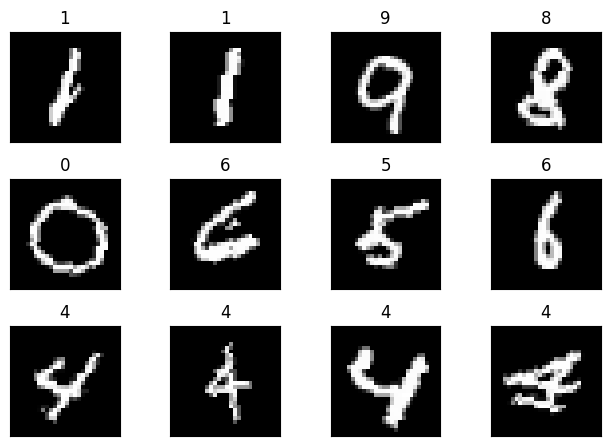

In [18]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

### MODEL BUILDING

In [19]:
%%writefile session5//model.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(4096, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2)  # ip: -1,1,28,28  op: -1,32,26,26  rf:3
        x = F.relu(F.max_pool2d(self.conv2(x), 2))  # ip: -1,32,26,26  op1: -1,64,24,24 op2: -1,64,12,12  rf:6
        x = F.relu(self.conv3(x), 2) # ip: -1,64,12,12 op : -1,128,10,10 rf: 10
        x = F.relu(F.max_pool2d(self.conv4(x), 2)) # ip: -1,128,10,10  op1: -1,256,8,8  op2: -1,256,4,4  rf:16
        x = x.view(-1, 4096) # ip: -1,256,4,4  op: -1, 4*4*256 ie flatten
        x = F.relu(self.fc1(x)) # ip: -1,4096  op: -1,50
        x = self.fc2(x) # ip: -1,50 op: -1,10
        return F.log_softmax(x, dim=1)

Overwriting session5//model.py


#### importing the model from model.py

In [20]:
from session5.model import Net

In [21]:
model = Net().to(device)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


In [22]:
%%writefile session5//train_utils.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

# adding training and testing functions
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

# use this training and test method in all codes ***
def train_loop(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0
  train_acc = []
  train_losses = []

  for batch_idx, (data, target) in enumerate(pbar):
    # print(f"train batch size:{data.shape}" )
    # print(f"train batch size:{target.shape}")
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

  return train_acc,train_losses

def test_loop(model, device, test_loader, criterion):
    model.eval()
    pbar = tqdm(test_loader)
    test_loss = 0
    correct = 0
    test_acc =[]
    test_losses = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)
            pbar.set_description(desc= f'Test: Loss={test_loss/len(test_loader.dataset):0.4f} Accuracy={100*correct/len(test_loader.dataset):0.2f}')


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    return test_acc,test_losses

Overwriting session5//train_utils.py


In [ ]:
# use %%writefile -a session5//train_utils.py to append something to existing

In [23]:
from session5.train_utils import train_loop,test_loop

#### Setting up Model starters

In [24]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True) #Decays the learning rate of each parameter group by gamma every step_size epochs
# New Line
criterion = F.nll_loss # refer:: https://stackoverflow.com/questions/65192475/pytorch-logsoftmax-vs-softmax-for-crossentropyloss

Adjusting learning rate of group 0 to 1.0000e-02.


#### Model Training for all the epochs

In [25]:
# for every epoch train and validate the model perf
for epoch in range(1, epochs+1):
  print(f'Epoch {epoch}')
  train_acc,train_losses = train_loop(model, device, train_loader, optimizer, criterion)
  test_acc,test_losses = test_loop(model, device, test_loader, criterion)
  scheduler.step()

Epoch 1


Test: Loss=0.0857 Accuracy=97.32: 100%|██████████| 79/79 [00:03<00:00, 22.87it/s]


Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Test: Loss=0.0564 Accuracy=98.24: 100%|██████████| 79/79 [00:03<00:00, 23.19it/s]


Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Test: Loss=0.0496 Accuracy=98.45: 100%|██████████| 79/79 [00:03<00:00, 23.47it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
